# CNN 구현
CNN 자체는 합성곱층과 풀링층을 추가하는 것만으로 구현할 수 있지만
이번은 데이터 확장과 드롭아웃의 구현도 실시해보자.

학습에 시간이 걸리므로 하드웨어 가속기에서 GPU를 선택하자.

##1. DataLoader의 설정
- 데이터를 확장하기 위해 회전과 크기 조절 및 좌우 반전을 실시한다.
- 효율적인 학습이 되도록 입력의 평균값을 0, 표준 편차를 1로 한다. <- 표준화

DataLoader는 훈련 데이터, 테스트 데이터 각각에서 설정한다.

In [10]:
# DataLoader 설정

from torchvision.datasets  import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

affine = transforms.RandomAffine((-30, 30), scale=(0.8, 1.2)) # 회전과 크기 조절
flip = transforms.RandomHorizontalFlip(p=0.5) # 좌우 반전
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)) # 평균값을 0, 표준편차를 1로
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoader의 설정

batch_size = 64 # 보통 32, 64, 128, 256를 연구자들과 개발자들이 많이 사용한다함
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## 2. CNN 모델의 구축
- nn.Module() 클래스를 상속한 클래스로서 CNN 모델을 구축한다.
- 합성곱층의 뒤에는 활성화 함수로 ReLU를 배치하고 그다음에 풀링층을 놓는다.
- 풀링층과 ReLU 층은 학습하는 파라미터가 없으므로 한 번 설정하면 다시 사용할 수 있다.
- 또한 범화 성능 향상을 위해서 드롭아웃을 도입한다.

In [11]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 8, 5) # 합성곱층(입력 채널 수, 필터 수, 필터 크기)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2) # 풀링층(영역의 크기, 영역의 간격)
    self.conv2 = nn.Conv2d(8, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 256) # 전결합층
    self.dropout = nn.Dropout(p=0.5) # 드롭아웃(p=드롭아웃률)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(-1, 16*5*5)
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 학습
CNN 모델을 훈련한다.
DataLoader를 사용하여 미니 배치를 꺼내서 훈련 및 평가를 실시함.

In [13]:
from torch import optim
import torch.nn as nn

# 교차 엔트로피 오차 함수
loss_fnc = nn.CrossEntropyLoss()

# 최적화 알고리즘
optimizer = optim.Adam(net.parameters())

# 손실로그
record_loss_train = []
record_loss_test = []

# 학습
for i in range(20):  # 20 에포크 학습
  net.train() # 훈련 모드
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):  # 미니배치(x, t)를 꺼낸다.
    x, t = x.cuda(), t.cuda() # GPU 대응
    y = net(x)
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)

  net.eval() # 평가 모드
  loss_test = 0
  for j, (x, t) in enumerate(test_loader):  # 미니배치(x, t)를 꺼낸다.
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(y, t)
    loss_test += loss.item()
  loss_test /=j+1
  record_loss_test.append(loss_test)

  if i%1 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)


Epoch: 0 Loss_Train: 1.5955300445446883 Loss_Test: 1.433427037327153
Epoch: 1 Loss_Train: 1.5284539723335324 Loss_Test: 1.357576649659758
Epoch: 2 Loss_Train: 1.4856165905132928 Loss_Test: 1.3342090647691374
Epoch: 3 Loss_Train: 1.4521359796719173 Loss_Test: 1.2903779373047457
Epoch: 4 Loss_Train: 1.4279008524497148 Loss_Test: 1.283574741357451
Epoch: 5 Loss_Train: 1.4043568766025631 Loss_Test: 1.2705859458370574
Epoch: 6 Loss_Train: 1.38354177494793 Loss_Test: 1.2361958979801009
Epoch: 7 Loss_Train: 1.3697220146503595 Loss_Test: 1.198911506279259
Epoch: 8 Loss_Train: 1.35040486133312 Loss_Test: 1.205206523275679
Epoch: 9 Loss_Train: 1.3433494733270173 Loss_Test: 1.1819551503582366
Epoch: 10 Loss_Train: 1.3240805017521313 Loss_Test: 1.163431487265666
Epoch: 11 Loss_Train: 1.3246998190117614 Loss_Test: 1.154318314449043
Epoch: 12 Loss_Train: 1.3140850628885772 Loss_Test: 1.145892205891336
Epoch: 13 Loss_Train: 1.307621913187949 Loss_Test: 1.1793507869076576
Epoch: 14 Loss_Train: 1.30385

# 오차추이
훈련 데이터와 테스트 데이터, 각각의 오차 추이를 그래프로 표시

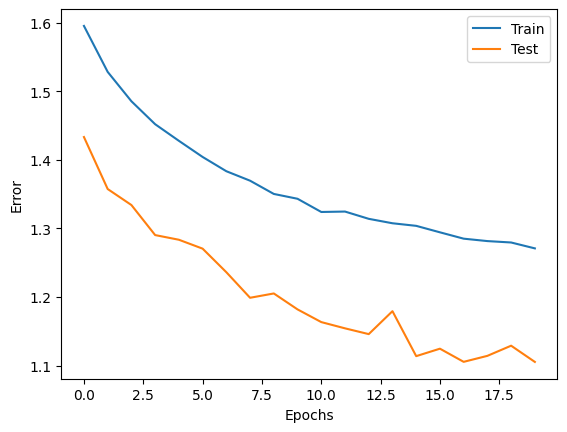

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# 정답률
모델의 성능을 파악하기 위해 테스트 데이터를 사용하여 정답률을 측정함.

In [17]:
correct = 0
total = 0

net.eval() # 평가모드
for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda() # GPU대응
  y = net(x)
  correct += (y.argmax(1) == t).sum().item()
  total += len(x)

print("정답률:", str(correct/total*100)+"%")

정답률: 60.370000000000005%


# 훈련한 모델을 사용한 예측
훈련한 모델을 사용해 보자.
이미지를 입력하고, 모델이 잘 동작하는지 확인한다.

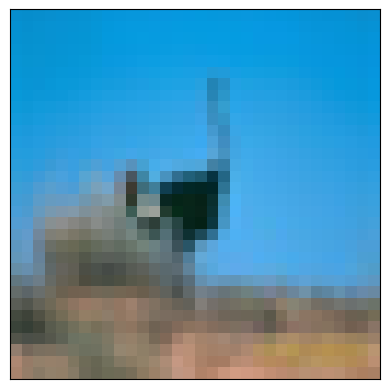

정답: bird 예측 결과: bird


In [20]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = next(dataiter) # 샘플을 1개만 꺼낸다.

plt.imshow(images[0].permute(1, 2, 0)) # 채널을 가장 뒤로
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False) # 라벨과 메모리를 표시하지 않는다.
plt.show()

net.eval() # 평가모드
x, t = images.cuda(), labels.cuda() # GPU 대응
y = net(x)
print("정답:", cifar10_classes[labels[0]], "예측 결과:", cifar10_classes[y.argmax().item()])

# 연습

## 1. DataLoader의 설정
- 새로운 데이터 확장을 추가하기
- transforms.RandomErasing() 클래스에 의해 이미지의 영역이 무작위로 소거됨.

In [27]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
affine = transforms.RandomAffine((-30, 30), scale=(0.8, 1.2)) # 회전과 크기 조절
flip = transforms.RandomHorizontalFlip(p=0.5) # 좌우반전
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)) # 평균값 0 , 표준편차 1

to_tensor = transforms.ToTensor()
erase = transforms.RandomErasing(p=0.5)

transform_train = transforms.Compose([affine, flip, to_tensor, normalize, erase])
transform_test = transforms.Compose([to_tensor, normalize])

cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# Dataloader의 설정
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## 2. CNN 모델의 구축
forwar() 메서드의 내부에 코드를 기술하고,
CNN 구축하기

In [29]:
import torch.nn as nn
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 8, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 256)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = x.view(-1, 16*5*5) # 텐서의 모양을 변경하기 위해 사용
    x = self.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

  net = Net()
  net.cuda()
  print(net)


Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 3. 학습
CNN 모델의 훈련

In [22]:
from torch import optim

# 교차 엔트로피 오차 함수
loss_fnc = nn.CrossEntropyLoss()

# 최적화 알고리즘
optimizer = optim.Adam(net.parameters())

# 손실로그
record_loss_train = []
record_loss_test = []

# 학습
for i in range(20):
  net.train()
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(x, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)

  net.eval()
  loss_test = 0
  for j, (x, t) in enumarate(test_loader):
    x, t = x.cuda(), t.cuda()
    y = net(x)
    loss = loss_fnc(x, t)
    loss_train += loss.item()
  loss_test /= j+1
  record_loss_test.append(loss_test)

  if i%1 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)


RuntimeError: ignored

## 4. 오차 추이

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 5. 정답률

In [23]:
correct = 0
total = 0
net.eval()
for i, (x, t) in enumerate(test_loader):
  x, t = x.cuda(), t.cuda()
  y = net(x)
  correct += (y.argmax(1) == t).sum().item()
  total += len(x)

print("정답률:", str(correct/total*100) + "%")

정답률: 60.370000000000005%


## 6. 훈련한 모델을 사용한 예측

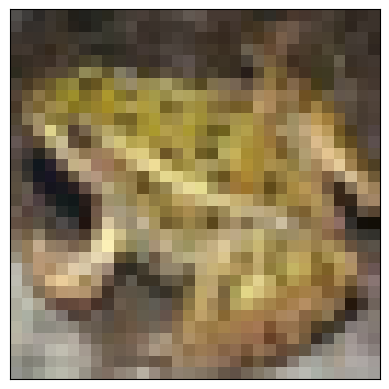

NameError: ignored

In [24]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = next(dataiter) # 샘플을 1개만 꺼낸다

plt.imshow(images[0].permute(1, 2, 0)) # 채널을 가장 뒤로
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()

net.eval()
x, t = images,cuda(), labels.cuda()
y = net(x)
print("정답:", cifar10_classes[labels[0]], "예측결과:", cifar10_classes[y.argmax().item()])